In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

tf.random.set_random_seed(13)

In [59]:
data_path  = "../data/jena_climate_2009_2016.csv"
weather_df = pd.read_csv(data_path)

columns = list(weather_df.columns)
    
new_columns = [
    "datetime",
    "pressure",
    "temp",
    "t_pot",
    "t_dew",
    "rh",
    "vp_max",
    "vp_act",
    "vp_def",
    "sh",
    "water_c",
    "rho",
    "wv",
    "wv_max",
    "wd"
] 

new_col_dict = dict(zip(columns, new_columns))
weather_df = weather_df.rename(columns=new_col_dict)

print("\nNumber of records: {}".format(weather_df.shape[0]))

weather_df.head()


Number of records: 420551


,datetime,pressure,temp,t_pot,t_dew,rh,vp_max,vp_act,vp_def,sh,water_c,rho,wv,wv_max,wd
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [60]:
train_split = 300_000

datetime
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: temp, dtype: float64

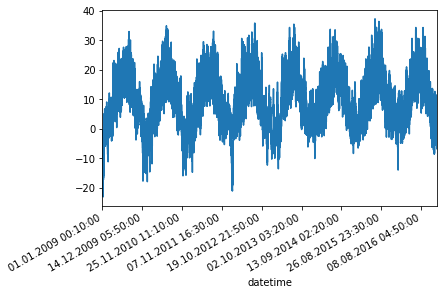

In [61]:
temp_df = weather_df["temp"]
temp_df.index = weather_df["datetime"]
temp_data = temp_df.values

temp_df.plot(subplots=True)

temp_df.head()

In [62]:
train_temp_data = temp_data[:train_split]
test_temp_data  = temp_data[train_split:]

train_mean = train_temp_data.mean()
train_std  = train_temp_data.std()

norm_data = (temp_data - train_mean) / train_std

In [63]:
history_size = 20
target_size  = 0

def time_series_split(input_data, start_index, end_index, history_size, target_size):
        
    data   = []
    labels = []
    
    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(input_data) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        
        reshaped_input = np.reshape(input_data[indices], (history_size, 1))
        
        data.append(reshaped_input)
        labels.append(input_data[i + target_size])
    
    return np.array(data), np.array(labels)

X_train, y_train = time_series_split(
    input_data=norm_data,
    start_index=0,
    end_index=train_split,
    history_size=history_size,
    target_size=target_size
)

X_test, y_test = time_series_split(
    input_data=norm_data,
    start_index=train_split,
    end_index=None,
    history_size=history_size,
    target_size=target_size
)

print("Training data shape: {}".format(X_train.shape))
print("Validation data shape: {}".format(X_test.shape))

Training data shape: (299980, 20, 1)
Validation data shape: (120531, 20, 1)


In [64]:
print ('Single window of past history')
print (X_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<module 'matplotlib.pyplot' from '/home/mickey/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

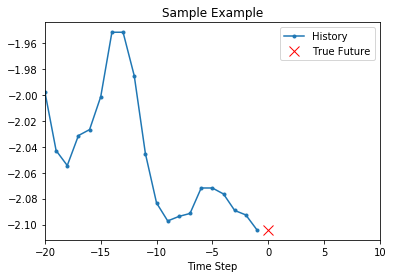

In [65]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length,0,1):
        time_steps.append(i)
    return time_steps

def show_history_plot(plot_data, delta, title):
    labels  = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(
                future,
                plot_data[i],
                markers[i],
                markersize=10,
                label=labels[i]
            )
        else:
            plt.plot(
                time_steps,
                plot_data[i].flatten(),
                markers[i],
                label=labels[i]
            )
        
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel("Time Step")
    
    return plt

show_history_plot([X_train[0], y_train[0]], 0, "Sample Example")

<module 'matplotlib.pyplot' from '/home/mickey/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

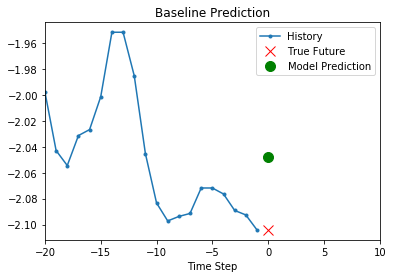

In [66]:
def baseline(history):
    return np.mean(history)

show_history_plot([X_train[0], y_train[0], baseline(X_train[0])] , 0, "Baseline Prediction")

In [67]:
batch_size = 256
buffer_size = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).repeat()

In [68]:
lstm_model = Sequential([
    LSTM(8, input_shape=X_train.shape[-2:]),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

In [73]:
predictions = lstm_model.predict(X_test)
print(predictions.shape)

(120531, 1)


In [76]:
eval_interval = 200
epochs = 10

lstm_model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=eval_interval,
    validation_data=test_dataset,
    validation_steps=50
)

Epoch 1/10
200/200 [==============================] - 7s 36ms/step - loss: 0.2347 - val_loss: 0.0153
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0360 - val_loss: 0.0027
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0087 - val_loss: 0.0021
Epoch 4/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0122 - val_loss: 0.0018
Epoch 5/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 6/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0022 - val_lo

<module 'matplotlib.pyplot' from '/home/mickey/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py'>

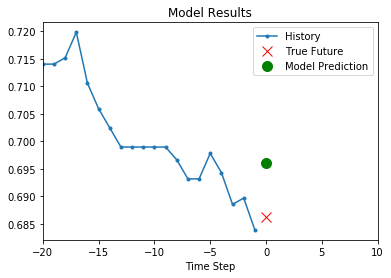

In [86]:
predictions = lstm_model.predict(X_test)

show_history_plot([X_test[100], y_test[100], predictions[100]] , 0, "Model Results")